# Lecture 10: Reservoir simulation and time series analysis
ENVR 890-001: Python for Environmental Research, Fall 2020

October 30, 2020

By Andrew Hamilton. Some material adapted from Greg Characklis, David Gorelick and H.B. Zeff.

## Summary
In this lecture, we will learn how to use **time series analysis** to create **synthetic streamflow records** using historical data. This will help us to improve our Monte Carlo analysis for a reservoir simulation model. We will use real data of historical inflows into Shasta Reservoir in northern California.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##read input data
shasta = pd.read_csv('shasta_inflow.csv', header=2)

## just care about inflow column
shasta = shasta.iloc[:, 0:2]
shasta.columns = ['date', 'inflow']
shasta

,date,inflow
0,Oct-80,"18,040"
1,Nov-80,"18,040"
2,Dec-80,"27,590"
3,Jan-81,"36,940"
4,Feb-81,"49,280"
...,...,...
475,May-20,"31,934"
476,Jun-20,"23,458"
477,Jul-20,"20,061"
478,Aug-20,"18,682"


In [2]:
## transform date to datetime type and set index 
##   (see here for datetime format specifiers: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)
shasta['date'] = pd.to_datetime(shasta['date'], format='%b-%y')
shasta.index = shasta['date']
shasta = shasta.iloc[:, [1]]
shasta

,inflow
date,
1980-10-01,"18,040"
1980-11-01,"18,040"
1980-12-01,"27,590"
1981-01-01,"36,940"
1981-02-01,"49,280"
...,...
2020-05-01,"31,934"
2020-06-01,"23,458"
2020-07-01,"20,061"


In [3]:
## create time step variable (note order of dates)
shasta['time'] = list(range(shasta.shape[0]))
shasta

,inflow,time
date,,
1980-10-01,"18,040",0
1980-11-01,"18,040",1
1980-12-01,"27,590",2
1981-01-01,"36,940",3
1981-02-01,"49,280",4
...,...,...
2020-05-01,"31,934",475
2020-06-01,"23,458",476
2020-07-01,"20,061",477


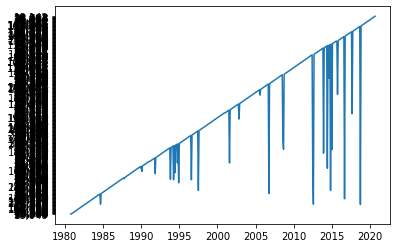

In [4]:
### plot data
plt.figure()
plt.plot(shasta['inflow'])

In [5]:
### weirdness here is because inflow is a string. turns out the data is formatted with commas at thousands. need to remove.
print(shasta['inflow'])
print()

shasta['inflow'] = [s.replace(',','') for s in shasta['inflow']]
print(shasta['inflow'])
print()

## now convert to numeric type
shasta['inflow'] = pd.to_numeric(shasta['inflow'])
shasta['inflow']

date
1980-10-01    18,040
1980-11-01    18,040
1980-12-01    27,590
1981-01-01    36,940
1981-02-01    49,280
               ...  
2020-05-01    31,934
2020-06-01    23,458
2020-07-01    20,061
2020-08-01    18,682
2020-09-01    18,143
Name: inflow, Length: 480, dtype: object

date
1980-10-01    18040
1980-11-01    18040
1980-12-01    27590
1981-01-01    36940
1981-02-01    49280
              ...  
2020-05-01    31934
2020-06-01    23458
2020-07-01    20061
2020-08-01    18682
2020-09-01    18143
Name: inflow, Length: 480, dtype: object



date
1980-10-01    18040
1980-11-01    18040
1980-12-01    27590
1981-01-01    36940
1981-02-01    49280
              ...  
2020-05-01    31934
2020-06-01    23458
2020-07-01    20061
2020-08-01    18682
2020-09-01    18143
Name: inflow, Length: 480, dtype: int64

(array([367.,  56.,  22.,  20.,   5.,   3.,   3.,   2.,   1.,   1.]),
 array([ 11800.,  52560.,  93320., 134080., 174840., 215600., 256360.,
        297120., 337880., 378640., 419400.]),
 <BarContainer object of 10 artists>)

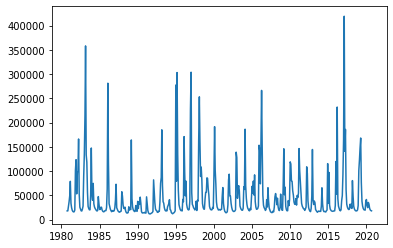

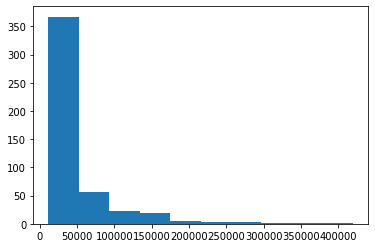

In [6]:
### plot data
plt.figure()
plt.plot(shasta['inflow'])

plt.figure()
plt.hist(shasta['inflow'])

In [7]:
### fit to lognormal distribution
from scipy.stats import lognorm, gamma, norm

ln_shape, ln_loc, ln_scale = lognorm.fit(shasta['inflow'])
ln_shape, ln_loc, ln_scale

(1.17000294351462, 11488.66279965279, 17421.080931349352)

In [8]:
### check fit
shasta['inflow'].mean()
print(f"Mean: data = {shasta['inflow'].mean()}, fit = {lognorm.mean(ln_shape, ln_loc, ln_scale)}")
print(f"Std: data = {shasta['inflow'].std()}, fit = {lognorm.std(ln_shape, ln_loc, ln_scale)}")

Mean: data = 46920.05, fit = 46029.228979321575
Std: data = 52118.67731949871, fit = 59134.531366248055


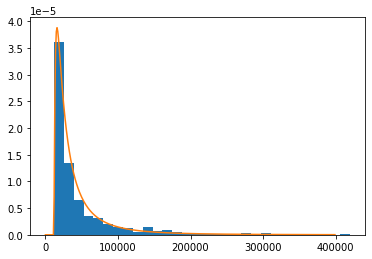

In [9]:
### plot theoretical distribution vs histogram
flow = np.arange(0, 400000, 1000)
ln_pdf = lognorm.pdf(flow, ln_shape, ln_loc, ln_scale)

plt.hist(shasta['inflow'], density=True, bins=30)
plt.plot(flow, ln_pdf)

In [10]:
### now generate a synthetic record of length 480 months (40 years)
shasta['synthetic1_inflow'] = lognorm.rvs(ln_shape, ln_loc, ln_scale, size=480)
shasta['synthetic1_inflow']

date
1980-10-01    114881.544148
1980-11-01     18010.212413
1980-12-01     53064.301113
1981-01-01     21992.309629
1981-02-01     72251.516684
                  ...      
2020-05-01     33519.012963
2020-06-01     26073.375601
2020-07-01     19172.927826
2020-08-01     39590.383968
2020-09-01     50158.195868
Name: synthetic1_inflow, Length: 480, dtype: float64

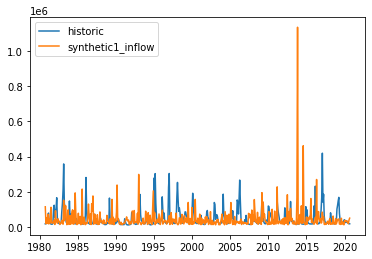

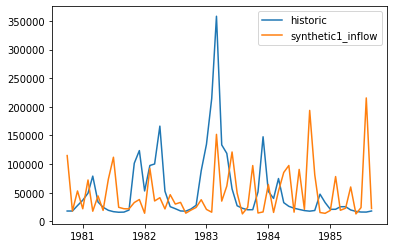

In [11]:
### plot historical vs synthetic
plt.figure()
plt.plot(shasta['inflow'], label='historic')
plt.plot(shasta['synthetic1_inflow'], label='synthetic1_inflow')
plt.legend()

### first 5 years
plt.figure()
plt.plot(shasta['inflow'].iloc[:60], label='historic')
plt.plot(shasta['synthetic1_inflow'].iloc[:60], label='synthetic1_inflow')
plt.legend()

In [12]:
### what about seasonality? we know that flow varies in predictable way from season to season.
shasta['month'] = shasta.index.month

monthly_mean = shasta.groupby('month').mean()['inflow']
monthly_std = shasta.groupby('month').std()['inflow']
monthly_std

month
1     66399.428282
2     84932.869224
3     73653.921698
4     54323.871697
5     30773.351441
6     13698.485590
7      5627.160451
8      4179.013259
9      4718.133359
10     8136.188860
11    15923.530043
12    49743.751787
Name: inflow, dtype: float64

Text(0, 0.5, 'inflow (AF)')

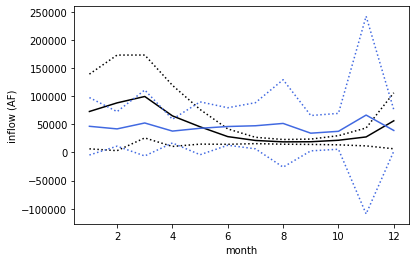

In [13]:
monthly_mean_synthetic1 = shasta.groupby('month').mean()['synthetic1_inflow']
monthly_std_synthetic1 = shasta.groupby('month').std()['synthetic1_inflow']

plt.plot(monthly_mean, color='k')
plt.plot(monthly_mean + monthly_std, color='k', ls=':')
plt.plot(monthly_mean - monthly_std, color='k', ls=':')

plt.plot(monthly_mean_synthetic1, color='royalblue')
plt.plot(monthly_mean_synthetic1 + monthly_std_synthetic1, color='royalblue', ls=':')
plt.plot(monthly_mean_synthetic1 - monthly_std_synthetic1, color='royalblue', ls=':')

plt.xlabel('month')
plt.ylabel('inflow (AF)')

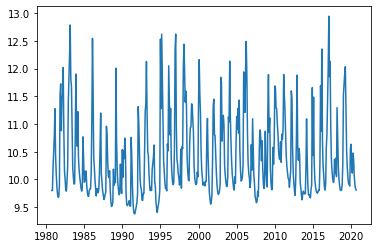

In [14]:
### Want to account for seasonality and autocorrelation. First log transform.
shasta['log'] = np.log(shasta['inflow'])
plt.plot(shasta['log'])

In [15]:
### check for trend over time? if so you would want to remove (then add back later) by working with residuals
import statsmodels.formula.api as sm

lm_log_time = sm.ols('log ~ time', data=shasta)
lm_log_time_fit = lm_log_time.fit()
print(lm_log_time_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    log   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.943
Date:                Tue, 26 Jan 2021   Prob (F-statistic):              0.164
Time:                        09:33:36   Log-Likelihood:                -534.02
No. Observations:                 480   AIC:                             1072.
Df Residuals:                     478   BIC:                             1080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3341      0.067    153.710      0.0

In [16]:
### seems to be no trend here, but if so you would want to remove (then add back later) by working with residuals

/home/andrew/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

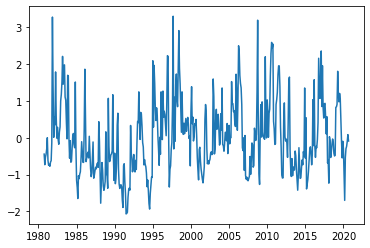

In [17]:
### There are a few ways to deal with this, but we will "deseasonalize" data by converting to monthly z-scores
monthly_mean_log = shasta.groupby('month').mean()['log']
monthly_std_log = shasta.groupby('month').std()['log']

shasta['deseas'] = shasta['log'].copy()
for i in range(1, 13):
    mu = monthly_mean_log[i]
    sigma = monthly_std_log[i]
    shasta['deseas'].loc[shasta['month'] == i] = (shasta['deseas'].loc[shasta['month'] == i] - mu) / sigma
    
plt.plot(shasta['deseas'])

(array([ 11.,  61., 101., 118.,  73.,  50.,  32.,  22.,   8.,   4.]),
 array([-2.06683404, -1.53048268, -0.99413133, -0.45777997,  0.07857138,
         0.61492274,  1.1512741 ,  1.68762545,  2.22397681,  2.76032816,
         3.29667952]),
 <BarContainer object of 10 artists>)

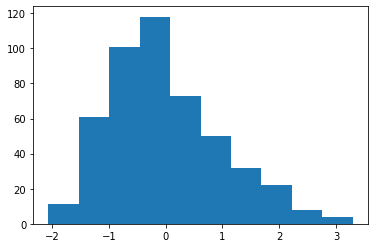

In [18]:
plt.hist(shasta['deseas'])

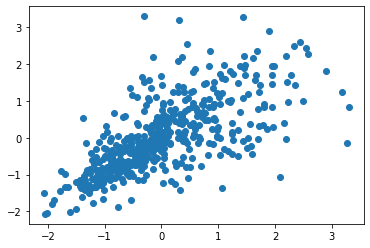

In [19]:
### This looks more random! But let's check whether autocorrelation seems significant
plt.figure()
plt.scatter(shasta['deseas'].iloc[1:], shasta['deseas'].iloc[:-1])

<Figure size 432x288 with 0 Axes>

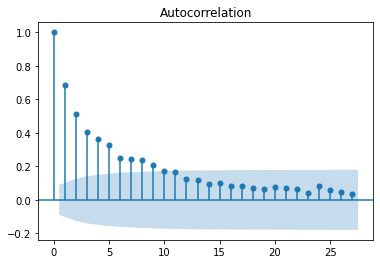

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure()
fig = plot_acf(shasta['deseas'])

In [21]:
shasta

,inflow,time,synthetic1_inflow,month,log,deseas
date,,,,,,
1980-10-01,18040,0,114881.544148,10,9.800347,-0.444284
1980-11-01,18040,1,18010.212413,11,9.800347,-0.731735
1980-12-01,27590,2,53064.301113,12,10.225209,-0.530423
1981-01-01,36940,3,21992.309629,1,10.517050,-0.444682
1981-02-01,49280,4,72251.516684,2,10.805274,-0.297438
...,...,...,...,...,...,...
2020-05-01,31934,475,33519.012963,5,10.371427,-0.299713
2020-06-01,23458,476,26073.375601,6,10.062967,-0.233931
2020-07-01,20061,477,19172.927826,7,9.906533,-0.101971


In [22]:
### create lag variables to deal with auto-correlation
shasta['deseas_l1'] = np.nan
shasta['deseas_l2'] = np.nan
shasta['deseas_l3'] = np.nan
shasta['deseas_l12'] = np.nan

shasta['deseas_l1'].iloc[1:] = shasta['deseas'].values[:-1]
shasta['deseas_l2'].iloc[2:] = shasta['deseas'].values[:-2]
shasta['deseas_l3'].iloc[3:] = shasta['deseas'].values[:-3]
shasta['deseas_l12'].iloc[12:] = shasta['deseas'].values[:-12]

shasta

/home/andrew/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,inflow,time,synthetic1_inflow,month,log,deseas,deseas_l1,deseas_l2,deseas_l3,deseas_l12
date,,,,,,,,,,
1980-10-01,18040,0,114881.544148,10,9.800347,-0.444284,NaN,NaN,NaN,NaN
1980-11-01,18040,1,18010.212413,11,9.800347,-0.731735,-0.444284,NaN,NaN,NaN
1980-12-01,27590,2,53064.301113,12,10.225209,-0.530423,-0.731735,-0.444284,NaN,NaN
1981-01-01,36940,3,21992.309629,1,10.517050,-0.444682,-0.530423,-0.731735,-0.444284,NaN
1981-02-01,49280,4,72251.516684,2,10.805274,-0.297438,-0.444682,-0.530423,-0.731735,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-05-01,31934,475,33519.012963,5,10.371427,-0.299713,-0.542635,-1.699564,-0.972306,1.206725
2020-06-01,23458,476,26073.375601,6,10.062967,-0.233931,-0.299713,-0.542635,-1.699564,0.973991
2020-07-01,20061,477,19172.927826,7,9.906533,-0.101971,-0.233931,-0.299713,-0.542635,1.203015


In [23]:
### set up autoregressive models with different lags
lm_log_ar = sm.ols('deseas ~ deseas_l1 + deseas_l2 + deseas_l3 + deseas_l12', data=shasta)
lm_log_ar_fit = lm_log_ar.fit()
print(lm_log_ar_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 deseas   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     104.6
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           2.19e-63
Time:                        09:33:37   Log-Likelihood:                -511.32
No. Observations:                 468   AIC:                             1033.
Df Residuals:                     463   BIC:                             1053.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0049      0.034      0.147      0.8

In [24]:
### set up autoregressive models with different lags
lm_log_ar = sm.ols('deseas ~ deseas_l1 + deseas_l2 + deseas_l3', data=shasta)
lm_log_ar_fit = lm_log_ar.fit()
print(lm_log_ar_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 deseas   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     143.7
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           3.50e-66
Time:                        09:33:37   Log-Likelihood:                -517.27
No. Observations:                 477   AIC:                             1043.
Df Residuals:                     473   BIC:                             1059.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0018      0.033      0.056      0.9

In [25]:
### set up autoregressive models with different lags
lm_log_ar = sm.ols('deseas ~ deseas_l1 + deseas_l2', data=shasta)
lm_log_ar_fit = lm_log_ar.fit()
print(lm_log_ar_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 deseas   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     215.5
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           2.53e-67
Time:                        09:33:37   Log-Likelihood:                -518.51
No. Observations:                 478   AIC:                             1043.
Df Residuals:                     475   BIC:                             1056.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0017      0.033      0.053      0.9

In [26]:
### set up autoregressive models with different lags
lm_log_ar = sm.ols('deseas ~ deseas_l1', data=shasta)
lm_log_ar_fit = lm_log_ar.fit()
print(lm_log_ar_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 deseas   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     428.5
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           2.15e-68
Time:                        09:33:37   Log-Likelihood:                -520.49
No. Observations:                 479   AIC:                             1045.
Df Residuals:                     477   BIC:                             1053.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0008      0.033      0.024      0.9

In [27]:
### set up autoregressive models with different lags
lm_log_ar = sm.ols('deseas ~ deseas_l1 + deseas_l12', data=shasta)
lm_log_ar_fit = lm_log_ar.fit()
print(lm_log_ar_fit.summary())
### although deseas_l12 is not significant, this one is still best in terms of AIC/BIC, so let's go with it.

                            OLS Regression Results                            
Dep. Variable:                 deseas   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     206.7
Date:                Tue, 26 Jan 2021   Prob (F-statistic):           5.89e-65
Time:                        09:33:37   Log-Likelihood:                -513.07
No. Observations:                 468   AIC:                             1032.
Df Residuals:                     465   BIC:                             1045.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0051      0.034      0.152      0.8

            inflow  time  synthetic1_inflow  month        log    deseas  \
date                                                                      
1980-10-01   18040     0      114881.544148     10   9.800347 -0.444284   
1980-11-01   18040     1       18010.212413     11   9.800347 -0.731735   
1980-12-01   27590     2       53064.301113     12  10.225209 -0.530423   
1981-01-01   36940     3       21992.309629      1  10.517050 -0.444682   
1981-02-01   49280     4       72251.516684      2  10.805274 -0.297438   
...            ...   ...                ...    ...        ...       ...   
2020-05-01   31934   475       33519.012963      5  10.371427 -0.299713   
2020-06-01   23458   476       26073.375601      6  10.062967 -0.233931   
2020-07-01   20061   477       19172.927826      7   9.906533 -0.101971   
2020-08-01   18682   478       39590.383968      8   9.835316  0.084289   
2020-09-01   18143   479       50158.195868      9   9.806040 -0.089005   

            deseas_l1  d

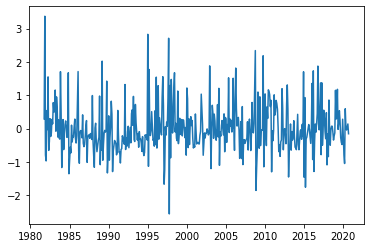

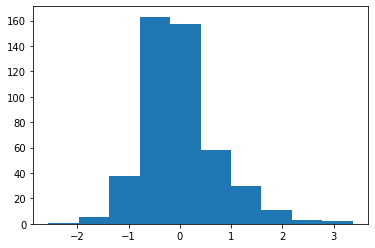

<Figure size 432x288 with 0 Axes>

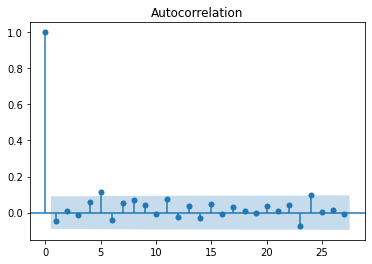

In [28]:
### now look at residuals to see if they look like "white noise" (uncorrelated & normally distributed)
shasta['ar_resid'] = lm_log_ar_fit.resid
print(shasta)

plt.figure()
plt.plot(shasta['ar_resid'])

plt.figure()
plt.hist(shasta['ar_resid'])

plt.figure()
fig = plot_acf(shasta['ar_resid'].iloc[12:])

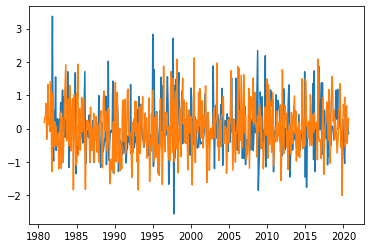

In [29]:
### ok, so we have "whitened" data! Now what? Now we can turn around and create synthetic data by reversing the process

## first, generate synthetic normally distributed data:
shasta['synthetic2_noise'] = norm.rvs(shasta['ar_resid'].mean(), shasta['ar_resid'].std(), size=shasta.shape[0])

plt.plot(shasta['ar_resid'])
plt.plot(shasta['synthetic2_noise'])

In [30]:
### now apply the AR relationship. here is a function to get regression prediction
def predict_ar(lag1, lag12):
    return lm_log_ar_fit.params[0] + lm_log_ar_fit.params[1] * lag1 + lm_log_ar_fit.params[2] * lag12

In [31]:
### We need 12 years of lagged data to start, we can use the last 12 years of real data
max_lag = 12
nrow = shasta.shape[0]

synth_ar = list(shasta['deseas'].iloc[-max_lag:])
synth_ar

[-0.09792584872618817,
 -0.5475876282161891,
 -0.09502852787233809,
 -0.2982314261607055,
 -0.9723064332676717,
 -1.6995636521606121,
 -0.5426345851536128,
 -0.29971257285774494,
 -0.2339307085905822,
 -0.10197063412202698,
 0.08428937601882568,
 -0.08900534098288752]

In [32]:
### now add prediction plus noise to get AR time series
for i in range(nrow):
    lag12 = synth_ar[i]
    lag1 = synth_ar[i + max_lag - 1]
    prediction = predict_ar(lag1, lag12)
    noise = shasta['synthetic2_noise'].iloc[i]
    synth_ar.append(prediction + noise)
    
shasta['synthetic2_deseas'] = synth_ar[-nrow:]
shasta

,inflow,time,synthetic1_inflow,month,log,deseas,deseas_l1,deseas_l2,deseas_l3,deseas_l12,ar_resid,synthetic2_noise,synthetic2_deseas
date,,,,,,,,,,,,,
1980-10-01,18040,0,114881.544148,10,9.800347,-0.444284,NaN,NaN,NaN,NaN,NaN,0.178656,0.121771
1980-11-01,18040,1,18010.212413,11,9.800347,-0.731735,-0.444284,NaN,NaN,NaN,NaN,0.338606,0.420622
1980-12-01,27590,2,53064.301113,12,10.225209,-0.530423,-0.731735,-0.444284,NaN,NaN,NaN,0.363002,0.654605
1981-01-01,36940,3,21992.309629,1,10.517050,-0.444682,-0.530423,-0.731735,-0.444284,NaN,NaN,0.750616,1.199845
1981-02-01,49280,4,72251.516684,2,10.805274,-0.297438,-0.444682,-0.530423,-0.731735,NaN,NaN,-0.323290,0.490922
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-01,31934,475,33519.012963,5,10.371427,-0.299713,-0.542635,-1.699564,-0.972306,1.206725,0.052203,0.536813,0.701929
2020-06-01,23458,476,26073.375601,6,10.062967,-0.233931,-0.299713,-0.542635,-1.699564,0.973991,-0.045411,0.679631,1.165452
2020-07-01,20061,477,19172.927826,7,9.906533,-0.101971,-0.233931,-0.299713,-0.542635,1.203015,0.038914,-0.441069,0.368543


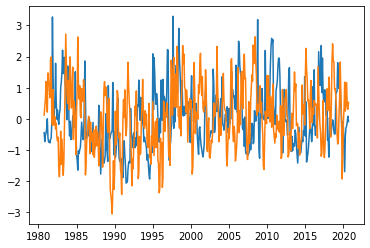

In [33]:
### this synthetic time series (noise + AR relationship) looks similar to our original deseasonalized data
plt.plot(shasta['deseas'])
plt.plot(shasta['synthetic2_deseas'])


/home/andrew/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/andrew/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

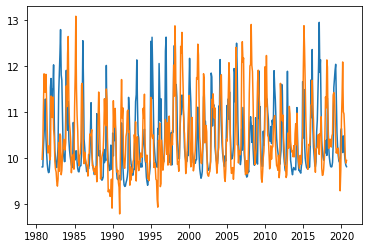

In [34]:
### next step is to reseasonalize by converting from monthly z-scores back to log-scale data
shasta['synthetic2_log'] = shasta['synthetic2_deseas'].copy()
for i in range(1, 13):
    mu = monthly_mean_log[i]
    sigma = monthly_std_log[i]
    shasta['synthetic2_log'].loc[shasta['month'] == i] = shasta['synthetic2_log'].loc[shasta['month'] == i] * sigma + mu
    
plt.plot(shasta['log'])
plt.plot(shasta['synthetic2_log'])

In [35]:
### lastly, we take the exp to convert from log scale back to inflows in AF
shasta['synthetic2_inflow'] = np.exp(shasta['synthetic2_log'])

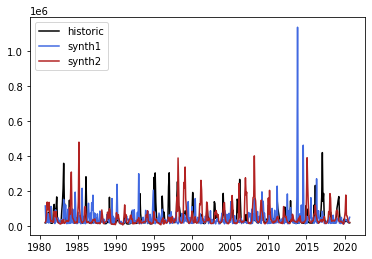

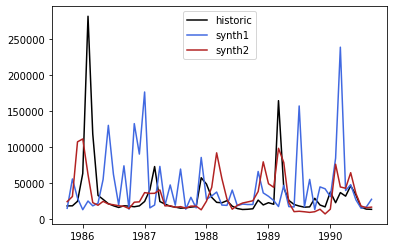

In [36]:
### plot original data vs synthetic1 vs synthetic2
plt.figure()
plt.plot(shasta['inflow'], color='k', label='historic')
plt.plot(shasta['synthetic1_inflow'], color='royalblue', label='synth1')
plt.plot(shasta['synthetic2_inflow'], color='firebrick', label='synth2')
plt.legend()

plt.figure()
plt.plot(shasta['inflow'].iloc[60:120], color='k', label='historic')
plt.plot(shasta['synthetic1_inflow'].iloc[60:120], color='royalblue', label='synth1')
plt.plot(shasta['synthetic2_inflow'].iloc[60:120], color='firebrick', label='synth2')
plt.legend()

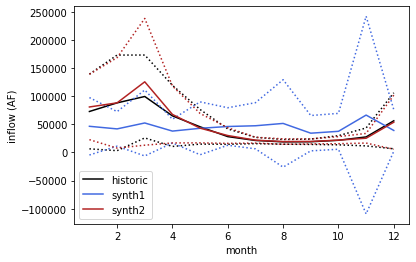

In [37]:
### look at monthly statistics (log space)
monthly_mean_synthetic2 = shasta.groupby('month').mean()['synthetic2_inflow']
monthly_std_synthetic2 = shasta.groupby('month').std()['synthetic2_inflow']

plt.plot(monthly_mean, color='k', label='historic')
plt.plot(monthly_mean + monthly_std, color='k', ls=':')
plt.plot(monthly_mean - monthly_std, color='k', ls=':')

plt.plot(monthly_mean_synthetic1, color='royalblue', label='synth1')
plt.plot(monthly_mean_synthetic1 + monthly_std_synthetic1, color='royalblue', ls=':')
plt.plot(monthly_mean_synthetic1 - monthly_std_synthetic1, color='royalblue', ls=':')

plt.plot(monthly_mean_synthetic2, color='firebrick', label='synth2')
plt.plot(monthly_mean_synthetic2 + monthly_std_synthetic2, color='firebrick', ls=':')
plt.plot(monthly_mean_synthetic2 - monthly_std_synthetic2, color='firebrick', ls=':')

plt.xlabel('month')
plt.ylabel('inflow (AF)')
plt.legend()

In [38]:
### Now what can we do with this? Run it through (very simplified) Shasta Reservoir!
storage_max = 4.5e6    ## max storage at shasta is ~4.5 million AF
storage_tmin1 = 2.25e6   ## let's assume it starts half full
inflow = list(shasta['inflow'])   ## inflow in AF/month
demand = shasta['inflow'].mean() * 0.8  ## assume demand is 80% of average inflow

### function for releases based on demand and max storage capacity
def get_release_storage(storage_tmin1, storage_max, inflow, demand):
    release = demand
    storage_t = storage_tmin1 + inflow - release
    if storage_t < 0:
        release += storage_t
        storage_t = 0
    elif storage_t > storage_max:
        release += (storage_t - storage_max)
        storage_t = storage_max
    return release, storage_t

release_1, storage_1 = get_release_storage(storage_tmin1, storage_max, inflow[0], demand)
release_1, storage_1

(37536.04, 2230503.96)

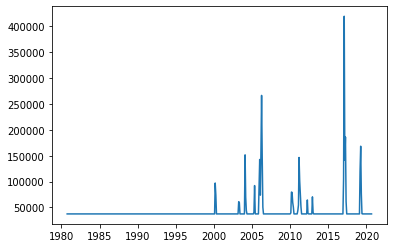

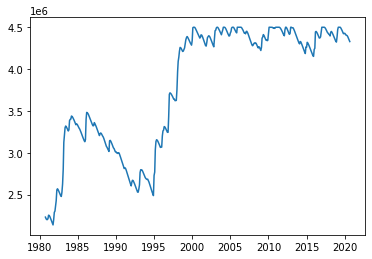

In [39]:
### run through simulation & store results in pandas
shasta['release'] = -1.
shasta['storage'] = -1.

for t in range(nrow):
    release, storage_t = get_release_storage(storage_tmin1, storage_max, inflow[t], demand)    
    shasta['release'].iloc[t] = release
    shasta['storage'].iloc[t] = storage_t
    storage_tmin1 = storage_t

shasta

plt.figure()
plt.plot(shasta['release'])

plt.figure()
plt.plot(shasta['storage'])

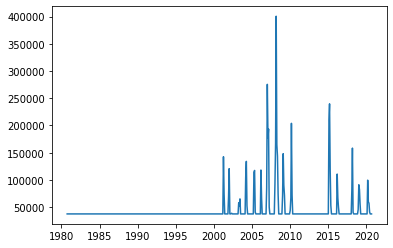

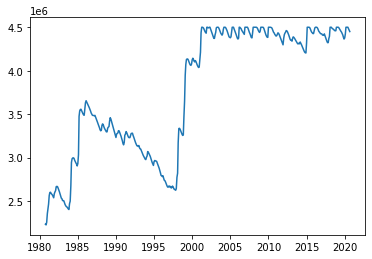

In [40]:
### repeat for synthetic data
storage_max = 4.5e6    ## max storage at shasta is ~4.5 million AF
storage_tmin1 = 2.25e6   ## let's assume it starts half full
inflow = list(shasta['synthetic2_inflow'])   ## inflow in AF/month
demand = shasta['inflow'].mean() * 0.8  ## assume demand is 80% of average (historical) inflow

shasta['synthetic2_release'] = -1.
shasta['synthetic2_storage'] = -1.

for t in range(nrow):
    release, storage_t = get_release_storage(storage_tmin1, storage_max, inflow[t], demand)    
    shasta['synthetic2_release'].iloc[t] = release
    shasta['synthetic2_storage'].iloc[t] = storage_t
    storage_tmin1 = storage_t

plt.figure()
plt.plot(shasta['synthetic2_release'])

plt.figure()
plt.plot(shasta['synthetic2_storage'])

In [41]:
### what if demand is expected to grow by 0.1%/month?
### repeat for synthetic data
storage_max = 4.5e6    ## max storage at shasta is ~4.5 million AF
storage_tmin1 = 2.25e6   ## let's assume it starts half full
inflow = list(shasta['synthetic2_inflow'])   ## inflow in AF/month

demand_0 = shasta['inflow'].mean() * 0.8  ## assume demand is 80% of average (historical) inflow at start
demand = [demand_0 * (1.001)**t for t in range(nrow)]
# demand

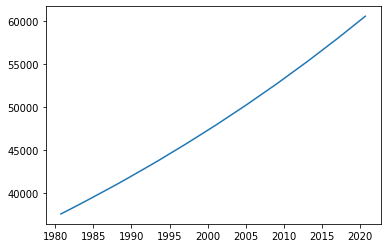

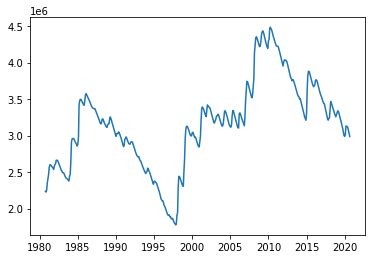

In [42]:
shasta['synthetic2_release'] = -1.
shasta['synthetic2_storage'] = -1.

for t in range(nrow):
    release, storage_t = get_release_storage(storage_tmin1, storage_max, inflow[t], demand[t])    
    shasta['synthetic2_release'].iloc[t] = release
    shasta['synthetic2_storage'].iloc[t] = storage_t
    storage_tmin1 = storage_t

plt.figure()
plt.plot(shasta['synthetic2_release'])

plt.figure()
plt.plot(shasta['synthetic2_storage'])

***In your homework***, you will see how to combine time series analysis with Monte Carlo simulation from last week. This will involve repeated sampling of 20-year time series, and then probabilistic analysis of metrics of interest from the simulation. 

For now, let's generate 10,000 different synthetic inflow scenarios, each of which is 20 years (240 months) long. We will store the final synthetic inflows in a 10,000x240 NumPy array. We want to use NumPy arrays rather than Pandas for all synthetic generation steps (e.g. white noise, deseasonalized residual, etc), since this is significantly faster and simpler when dealing with a lot of repitition.

In [43]:
## variables for sythetic data
nyear = 20
nmonth = nyear * 12
nsim = 10000

## first, generate synthetic normally distributed data:
noise = norm.rvs(shasta['ar_resid'].mean(), shasta['ar_resid'].std(), size=(nsim, nmonth))

print(noise.shape)
print(noise)

(10000, 240)
[[ 0.58780411 -1.72563719 -0.10635834 ... -0.57030258  0.63904325
   0.28372727]
 [ 0.02539586  0.69151012  0.3505246  ... -0.68341048  0.11217919
  -1.49344143]
 [-2.42999786  0.12961479 -0.37177003 ...  0.4280387   0.15804027
  -1.50793818]
 ...
 [ 1.15189798 -0.23668158 -0.13849252 ...  0.78081952  0.73628996
  -0.92320619]
 [-1.89791799  0.23785564 -0.73786243 ... -0.03576285  0.75790621
  -1.19363385]
 [-0.09153109 -0.26897751  0.62093091 ... -0.63924938  0.60399939
   0.51170247]]


In [44]:
### now apply the AR relationship. here is a function to apply regression prediction
def predict_ar(lag1, lag12):
    return lm_log_ar_fit.params[0] + lm_log_ar_fit.params[1] * lag1 + lm_log_ar_fit.params[2] * lag12

### We need 12 years of lagged data to start, we can use the last 12 years of real data
max_lag = 12
deseas = np.zeros((nsim, nmonth+max_lag))
deseas[:, :max_lag] = list(shasta['ar_resid'].iloc[-max_lag:])
### now add prediction plus noise to get AR time series
for i in range(nmonth):
    lag12 = deseas[:, i]
    lag1 = deseas[:, i + max_lag - 1]
    prediction = predict_ar(lag1, lag12)
    deseas[:, i + max_lag] = prediction + noise[:, i]

deseas = deseas[:, max_lag:]
    
print(deseas.shape)
print(deseas)

(10000, 240)
[[ 0.48066059 -1.39744982 -1.05350027 ... -1.22315472 -0.19123686
   0.16682274]
 [-0.08174767  0.63515557  0.79315951 ... -1.01923235 -0.59518547
  -1.89879283]
 [-2.53714138 -1.60559454 -1.46122915 ...  1.20682979  0.99414858
  -0.83695819]
 ...
 [ 1.04475446  0.47720022  0.19614175 ...  0.99363978  1.41989266
   0.0558683 ]
 [-2.00506151 -1.13354856 -1.50456409 ... -0.57255909  0.38922983
  -0.9281568 ]
 [-0.19867461 -0.40527987  0.35217684 ... -1.30107569 -0.2819441
   0.31970319]]


In [45]:
## now reseasonalize using the monthly means and stds, to get to log-scale inflows
month = [t % 12 + 1 for t in range(nmonth)]
log = deseas.copy()
for i in range(nmonth):
    mu = monthly_mean_log[month[i]]
    sigma = monthly_std_log[month[i]]
    log[:, i] = log[:, i] * sigma + mu
print(log.shape)
print(log)

(10000, 240)
[[11.25372659  9.91702266 10.55543831 ...  9.57099761 10.03343038
  10.7559759 ]
 [10.80598674 11.55833498 11.82024911 ...  9.63104538  9.85923221
   9.18355845]
 [ 8.85121882  9.74894749 10.2761774  ... 10.28654033 10.54461418
   9.99186341]
 ...
 [11.70280837 11.43078732 11.41134081 ... 10.22376356 10.72821139
  10.67151357]
 [ 9.27481388 10.13012078 10.24649652 ...  9.76257454 10.28374994
   9.9224399 ]
 [10.71289982 10.71819182 11.51821207 ...  9.54805269  9.99431393
  10.87235374]]


In [46]:
### lastly, exponentiate to get back to original scale (AF/month)
synth_inflow = np.exp(log)

print(synth_inflow.shape)
print(synth_inflow)

(10000, 240)
[[ 77166.95385576  20272.54237638  38385.62478938 ...  14342.71758198
   22775.26557165  46909.51890486]
 [ 49315.15598237 104645.63113661 135978.09768384 ...  15230.34935767
   19134.19269448   9735.73530897]
 [  6982.89465186  17136.18327035  29032.68086153 ...  29335.10870053
   37972.37405291  21847.97259981]
 ...
 [120910.8012063   92114.46942355  90340.4695791  ...  27550.15840527
   45625.01380929  43110.14237269]
 [ 10665.97323441  25087.394179    28183.62786329 ...  17371.29716678
   29253.3665509   20382.66160589]
 [ 44931.74396912  45170.15335397 100530.06066114 ...  14017.37195115
   21901.57717992  52699.10449791]]


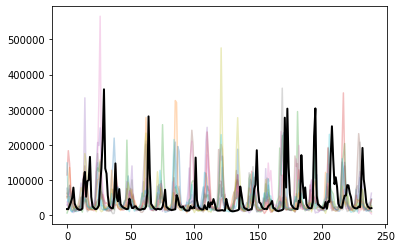

In [47]:
### plot next to original data to make sure it looks ok
for s in range(10):
    plt.plot(synth_inflow[s, :], alpha=0.3)
plt.plot(shasta['inflow'].iloc[:nmonth].values, color='k', lw=2)

In [48]:
### save data for homework
np.savetxt('synth_inflow.csv', synth_inflow, delimiter=',')

**This has been a very brief intro to the large field of time series analysis**. Here are some other interesting concepts that you can explore on your own if you are so inclined. Email me if you'd like a list of references.
1. Auto-regressive moving average (ARMA) models add correlated error terms to an AR model, which can help create more sustained devations from "normal" behavior
1. Auto-regressive integrated moving average (ARIMA) models add an "integration" term which accounts for linear trends
1. ARIMAX models add exogenous predictor variables (X) to an ARIMA model. For example maybe you want to provide an el nino-southern oscillation (ENSO) signal that effects inflows.
1. Fourier analysis is an alternative to manual deseasonalization, by breaking down the signal into harmonic waves
1. Wavelet analysis is a more "fuzzy" version of Fourier analysis, which allows for quasi-harmonic signals (e.g., ENSO)
1. Multivariate synthetic time series with copulas, vector auto-regression, and other methods
2. Semiparametric sampling for finer-scale structure that is hard to capture with parametric methods (e.g., daily streamflow is much more irregular than monthly streamflow).
1. Hidden Markov Models are another cool alternative, which allows for random transitions between different "regimes" (e.g., wet period vs dry period), and then different probability distributions for streamflow within each regime